## 목표
---
1. **ResNet-34, ResNet-50 모델 구현**  
    - 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력됨
2. **구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련**
    - cats_vs_dogs 데이터셋으로 학습시 안정적인 loss, accuracy 그래프 확인

3. **Ablation Study 결과 도출**
    - ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표작성

---


## 논문 소개
---
이번 Project에서 구현할 논문은 ResNet 구조로 유명한 [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)입니다.

0. 초록 
- 딥러닝의 neural network가 깊어질수록 모델의 성능은 좋아지지만, train하는것이 어렵다.
- 그래서 이 논문에서는 learning function을 새로 구성하는 대신, residual function을 사용하여 레이어를 재구성하여 이 문제를 해결하려 합니다.
- 그리고 Residual network를 사용하여 optimize를 더 쉽게하고, accuracy를 증가시키고, layer를 더 깊게 쌓을 수 있다는 것을 실험한 데이터를 통해 증명합니다. 
- 이 **residaul network를 통해 VGG와 비교하여 152 layer까지 더 깊게 쌓으면서도 complexity는 낮은 것**을 보여줍니다.(신기방기...)
- 또한 이 구조를 통해 이미지 classification 뿐만 아니라 object detection, segmentation등 다양한 분야에 적용하여 높은 성능을 보여줍니다. (이래서 진짜 많은 분야에서 이 논문을 인용한것이겠죠?)

1. Introduction
- 이전에 나온 많은 논문들을 통해 deep learning에서 모델의 layer가 deep할수록 성능이 좋아진 다고 알려져 있습니다. 하지만 **레이어를 깊게 쌓는만큼 network의 성능이 좋아지는가?**라는 질문이 따라옵니다. 왜냐면 layer를 깊게 쌓을수록  problem of vanishing/exploding gradients라는 문제들이 따라오기 때문입니다. 그래도 normalization,  intermediate normalization layers 같은 방법을 통해 해결하고 있긴 합니다. 
- 이 논문에서 핵심적으로 다룰 문제는 D**egradation Problem 입니다. network가 깊어질수록 accuracy가 떨어지는 문제**가 생기는데, 이건 overfitting으로 야기되는 문제가 아니기 때문입니다.(overfitting이면 deep layer train 시, train accuracy는 높고 test accuracy는 낮아야하는데 이 경우엔 둘다 낮기 때문)
    - 딥러닝 모델의 레이어가 깊어졌을 때 모델이 수렴했음에도 불구하고 오히려 레이어 개수가 적을 때보다 모델의 training/test error가 더 커지는 현상이 발생하는데, 이것은 오버피팅 때문이 아니라 네트워크 구조상 레이어를 깊이 쌓았을 때 최적화가 잘 안되기 때문에 발생하는 문제이다.

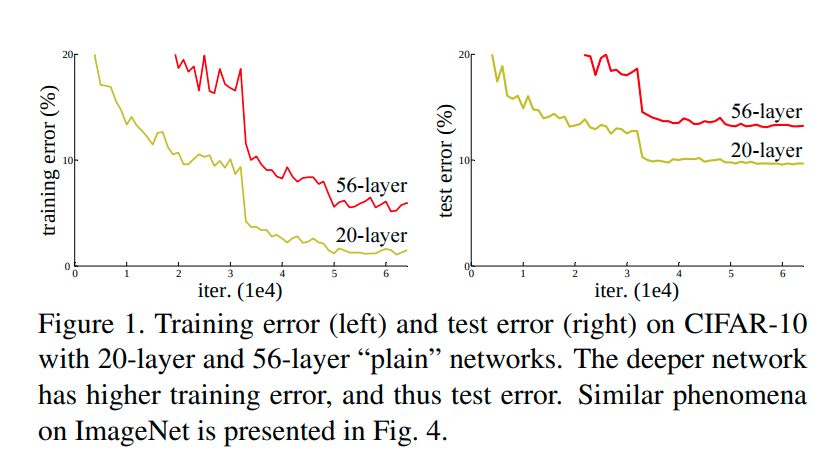

## STEP 0. 라이브러리 불러오기
---

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import shutil
import zipfile
import glob
import pandas as pd
import warnings
import tensorflow_datasets as tfds
from tensorflow.python.client import device_lib
warnings.filterwarnings("ignore")

In [20]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## STEP 1. ResNet 기본 블록 구성하기
---
ResNet-34와 ResNet-50 블록의 공통점을 찾아 기본 블록을 구성해보자.

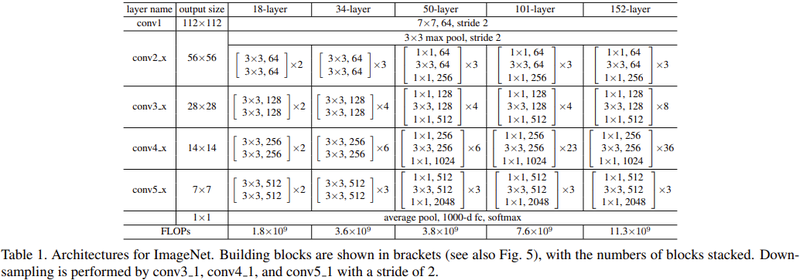

- 공통점 : conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태
- 차이점 : ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다름. 
    - ResNet-34 : 3x3 kernel인 Convolution layer로만 구성
    - ResNet-50 : 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록내에 가지게 됨


### ResNet-34 모델
---

우선 기본 블럭만 만들고 input lyaer(maxpooling포함), Output layer(sigmoid 포함)은 나중에 클래스로 묶을 때 따로 만들기로 하자. 

In [21]:
############ ResNet 34 Block 만들기 ####################
def build_34_layer_block(input_layer,
                          num_cnn = 3,
                          channel = 64,
                          block_num = 1,
                          strides = 1,
                          is_residual = True):
    
    #입력 레이어
    x = input_layer

    #CNN 레이어
    for cnn_num in range(num_cnn):
        #identity mapping 설정
        identity_mapping = x
        ########### layer1 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = channel,
                                kernel_size = (3,3),
                                strides = strides,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}'
                                )(x)
                                
        # conv2D 다음 Batch normalization
        x = keras.layers.BatchNormalization()(x)
        # BN 다음 activation(relu)
        x = keras.layers.Activation('relu')(x)

        ########### layer2 ##############
        # conv2D
        x = keras.layers.Conv2D(filters = channel,
                                strides = 1,
                                kernel_size = (3,3),
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'blcok{block_num}_conv{cnn_num}'
                                )(x)
        # conv2D 다음 Batch normalization
        x = keras.layers.BatchNormalization()(x)

        if is_residual:
            ########### skip connection #############
           if strides != 1 :
                # identity mapping conv 진행
                identity_mapping = keras.layers.Conv2D(filters = channel,
                                                    kernel_size = (1,1),
                                                    strides = 2)(identity_mapping)
                # conv2D 다음 Batch normalization
                identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
                # 다음 스텝용 strides 변경
                srides = 1

           ########### Shortcut connection ##############
           #identity mapping 더해주는 레이어
           x = keras.layers.Add()([x, identity_mapping])
           # Add 후 activation(relu)

        x = keras.layers.Activation('relu')(x)


    return x


Ok.... 우선 블럭 1개짜리는 잘 생성되었습니다!!!

그럼 이제 input에서 maxpooling과 나머지 블록들까지 합쳐서 ResNet 34 model을 만들어 봅시다. 

In [22]:
############ ResNet 34 Model 만들기 ####################
def build_resnet_34(input_shape = (32,32,3),
                 num_cnn_list = [3,4,6,3],
                 channel_list = [64,128,256,512],
                 num_classes = 10,
                 is_residual = True):
    
    # 모델 돌리기 전에 config list 길이 확인
    assert len(num_cnn_list) == len(channel_list)


    ############ input layer 생성 ###########
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2,
                                 kernel_initializer = 'he_normal',
                                 padding = 'same',
                                 name = 'conv2D_1st')(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)

    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1, 1),
                               strides = 2)(output)
    
    ############# Conv layer 생성 ###############
    #config list 길이만큼 반복해서 블록 생성 
    prev_channel = channel_list[0]
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        #채널이 변할때 stride 변화
        strides = 1 if channel == prev_channel else 2
        output = build_34_layer_block(output,
                                       num_cnn = num_cnn,
                                       channel = channel,
                                       strides = strides,
                                       block_num = i)
        prev_channel = channel

    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model



In [23]:
resnet_34 = build_resnet_34(input_shape=(32,32,3))
resnet_34.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_1st (Conv2D)            (None, 16, 16, 64)   256         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization_304 (Batch  (None, 16, 16, 64)  256         ['conv2D_1st[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_198 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_304[0

### ResNet 50 모델

---


In [65]:
############ ResNet 50 Block 만들기 ####################
def build_50_layer_block(input_layer,
                          num_cnn = 3,
                          channel = 64,
                          block_num = 1,
                          strides = 1,
                          is_residual = True):
    
    #입력 레이어
    x = input_layer
    identity_mapping = x
    identity_mapping = keras.layers.Conv2D(filters = (channel * 4),
                                                        kernel_size = (1,1),
                                                        padding = 'same',
                                                        strides = strides)(identity_mapping)
    identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
    
    #CNN 레이어
    for cnn_num in range(num_cnn):
        ########### layer1 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = channel,
                                kernel_size = (1,1),
                                strides = strides,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}_1x1_1st'
                                )(x)
                                
        # conv2D 다음 BN-ReLU
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        ########### layer2 ##############
        # conv2D
        x = keras.layers.Conv2D(filters = channel,
                                strides = 1,
                                kernel_size = (3,3),
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'blcok{block_num}_conv{cnn_num}_3x3'
                                )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        ########### layer3 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = (channel * 4),
                                kernel_size = (1,1),
                                strides = 1,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}_1x1_2nd'
                                )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Add()([x, identity_mapping])
        if is_residual:
            ########### Residual addition ##############
            if strides != 1: 
                strides = 1

        # Add 후 activation(relu)
        x = keras.layers.Activation('relu', name = f'block{block_num}_conv{cnn_num}_out')(x)
        # identity mapping 초기화
        identity_mapping = x

    return x


In [66]:
############ ResNet 50 Model 만들기 ####################
def build_resnet_50(input_shape = (32,32,3),
                 num_cnn_list = [3,4,6,3],
                 channel_list = [64,128,256,512],
                 num_classes = 10):
    
    # 모델 돌리기 전에 config list 길이 확인
    assert len(num_cnn_list) == len(channel_list)

    ############ input layer 생성 ###########
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2,
                                 kernel_initializer = 'he_normal',
                                 padding = 'same',
                                 name = 'conv2D_1st')(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1, 1),
                               strides = 2)(output)
    
    ############# Conv layer 생성 ###############
    #config list 길이만큼 반복해서 블록 생성 
    prev_channel = 64
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        strides = 1 if channel == prev_channel else 2
        output = build_50_layer_block(output,
                                       num_cnn = num_cnn,
                                       channel = channel,
                                       strides = strides,
                                       block_num = i)
        prev_channel = channel
        

    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model

In [67]:
resnet_50 = build_resnet_50()

resnet_50.summary()


# tf.keras.utils.plot_model(resnet_50, 'model.png', show_shapes = True)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_1st (Conv2D)            (None, 16, 16, 64)   256         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization_915 (Batch  (None, 16, 16, 64)  256         ['conv2D_1st[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_621 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_915[

In [27]:
############## build_resnet ##############
def build_resnet(input_shape, num_classes, is_50):
    
    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]

    # 50 일때 
    if is_50 :

        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)
        
        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)

        #config list 길이만큼 반복해서 블록 생성 
        prev_channel = channel_list[0]

        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_50_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i)
            prev_channel = channel

    else:
        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)

        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)
                                       
        prev_channel = channel_list[0]
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_34_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i)
            prev_channel = channel

        
    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model



In [28]:
resnet_34 = build_resnet(input_shape=(32, 32,3), num_classes = 10, is_50 =False)
resnet_34.summary()

# tf.keras.utils.plot_model(resnet_34, 'model.png', show_shapes = True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_1st (Conv2D)            (None, 16, 16, 64)   256         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization_415 (Batch  (None, 16, 16, 64)  256         ['conv2D_1st[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_264 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_415[0

In [29]:
resnet_50 = build_resnet(input_shape=(32, 32,3), num_classes = 10, is_50 = True)
resnet_50.summary()

# tf.keras.utils.plot_model(resnet_50, 'model.png', show_shapes = True)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2D_1st (Conv2D)            (None, 16, 16, 64)   256         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization_461 (Batch  (None, 16, 16, 64)  256         ['conv2D_1st[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_297 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_461[0

ResNet 모델들을 하나의 함수로 묶어 is_50 변수의 True, False로 변환하도록 만들었다. 그럼 plain모델도 이렇게 진행하도록 해보자! 

사실 기본 모델을 만들때 is_residual 변수를 넣어 plain의 on/off를 가능하게 만들었기때문에 간단히 진행 될 수 있을 거라 예상한다.

### plain 모델 
---


In [30]:
############## build_plane net ##############
def build_plainnet(input_shape, num_classes, is_50):
    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]

    # 50 일때 
    if is_50 :

        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)
        
        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)

        ############ Block layer ##############
        #config list 길이만큼 반복해서 블록 생성 
        prev_channel = channel_list[0]
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_50_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i,
                                        is_residual = False)
            prev_channel = channel

    else:

        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)

        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)

        ############ Block layer ##############
        prev_channel = channel_list[0]
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_34_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i,
                                        is_residual = False)
            prev_channel = channel

        
    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model

In [31]:
plainnet_34 = build_plainnet(input_shape=(32, 32,3), num_classes = 10, is_50 =False)
plainnet_34.summary()

# tf.keras.utils.plot_model(plainnet_34, 'model.png', show_shapes = True)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 conv2D_1st (Conv2D)         (None, 16, 16, 64)        256       
                                                                 
 batch_normalization_526 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_330 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 block0_conv0 (Conv2D)       (None, 8, 8, 64)          369

In [32]:
plainnet_50 = build_plainnet(input_shape=(32, 32,3), num_classes = 10, is_50 = True)
plainnet_50.summary()

# tf.keras.utils.plot_model(plainnet_50, 'model.png', show_shapes = True)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 conv2D_1st (Conv2D)         (None, 16, 16, 64)        256       
                                                                 
 batch_normalization_559 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_363 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 block0_conv0_1x1_1st (Conv2  (None, 8, 8, 64)         416

ResNet과 Plain 모델을 완성했습니다! 

그럼 이제 고양이 멈무미 데이터를 불러와서 학습시켜 비교해봅시다

## STEP2. Data Load 

---

test data를 로드해줍니다.   
이번에 사용할 데이터는 cats vs dogs 입니다.  
본 데이터를 불러와서 논문처럼 (224,224) 사이즈로 만들어 사용해줍니다.

In [33]:
BATCH_SIZE = 32
EPOCH = 50

In [38]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=('train[:80%]', 'train[80%:]'),
    shuffle_files=True,
    with_info=True,
    as_supervised = True)
    

print(ds_info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteM9JKKQ/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [39]:
#데이터 갯수도 확인해보자
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [40]:
print('label 수: ', ds_info.features['label'].num_classes)
print('label 이름: ', ds_info.features['label'].names)

label 수:  2
label 이름:  ['cat', 'dog']


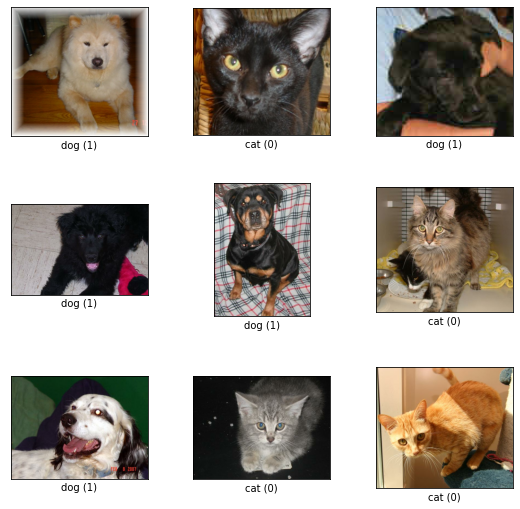

In [41]:
fig = tfds.show_examples(ds_train, ds_info)

귀....귀여워.....ㅎㅎ....   

하지만 각 이미지의 사이즈가 들쑥날쑥한 것을 볼 수 있습니다.  
이미지의 augmentation을 진행해서 과적합을 막아주고 학습을 시켜봅시다.

In [42]:
def resize_and_normalize(image, label):
    """Normalizes images : 'uin8' -> 'float32'.
    우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 
    이미지의 표현이 0과 1 사이로 들어오도록 만들어준다.
    """
    image = tf.image.resize(image, [224,224])
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    return image, label


In [43]:
def apply_normalize_on_dataset(image_data, is_test = False, batch_size = 16):
    image_data = image_data.map(resize_and_normalize, num_parallel_calls = 1)
    image_data = image_data.batch(batch_size)
    
    if not is_test:
        image_data = image_data.repeat()
        image_data = image_data.shuffle(200)
    
    image_data = image_data.prefetch(tf.data.experimental.AUTOTUNE)
    return image_data

In [44]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

Input에 맞춰 224,224로 맞춰주고 0~1로 정규화를 마치고 dataset까지 만들어주었습니다.   

그럼 이제 plain과 resnet에 서로 넣어 비교해볼까요?

## STEP 3. Plain VS ResNet 
---

### Plain VS ResNet - 34layers
---

In [45]:
# tensorflow가 활용할 GPU가 장착되어 있는지 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9728426942043819695
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3062488448950270985
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 conv2D_1st (Conv2D)         (None, 112, 112, 64)      256       
                                                                 
 batch_normalization_674 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_462 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 block0_conv0 (Conv2D)       (None, 56, 56, 64)        369

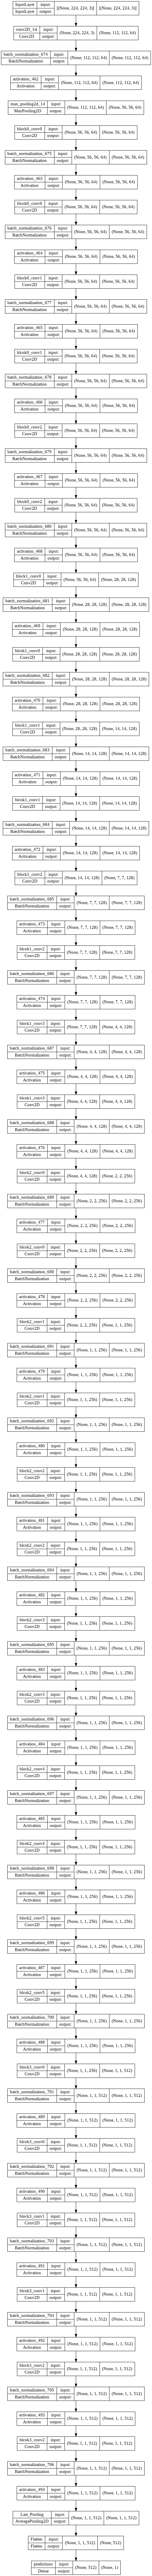

In [51]:
################# plainnet 34 model 생성 ########################
plainnet_34 = build_plainnet(input_shape=(224, 224,3), num_classes = 1, is_50 =False)

plainnet_34.summary()
tf.keras.utils.plot_model(plainnet_34, 'model.png', show_shapes = True)

In [52]:
################# plainnet 34 model 학습 ########################
with tf.device("/device:GPU:0"):
    plainnet_34.compile(
        loss='BinaryCrossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy']
    )

    history_plain34 = plainnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/50
581/581 [==============================] - 106s 121ms/step - loss: 0.7334 - accuracy: 0.5067 - val_loss: 0.8357 - val_accuracy: 0.5009
Epoch 2/50
581/581 [==============================] - 70s 120ms/step - loss: 0.7184 - accuracy: 0.4998 - val_loss: 0.7559 - val_accuracy: 0.5197
Epoch 3/50
581/581 [==============================] - 70s 120ms/step - loss: 0.7107 - accuracy: 0.5073 - val_loss: 0.9257 - val_accuracy: 0.5054
Epoch 4/50
581/581 [==============================] - 70s 120ms/step - loss: 0.7074 - accuracy: 0.5055 - val_loss: 0.7747 - val_accuracy: 0.4985
Epoch 5/50
581/581 [==============================] - 70s 120ms/step - loss: 0.7053 - accuracy: 0.5034 - val_loss: 0.7614 - val_accuracy: 0.5278
Epoch 6/50
581/581 [==============================] - 70s 120ms/step - loss: 0.6987 - accuracy: 0.5168 - val_loss: 0.7782 - val_accuracy: 0.5076
Epoch 7/50
581/581 [==============================] - 70s 120ms/step - loss: 0.6957 - accuracy: 0.5234 - val_loss: 0.7410 - val_a

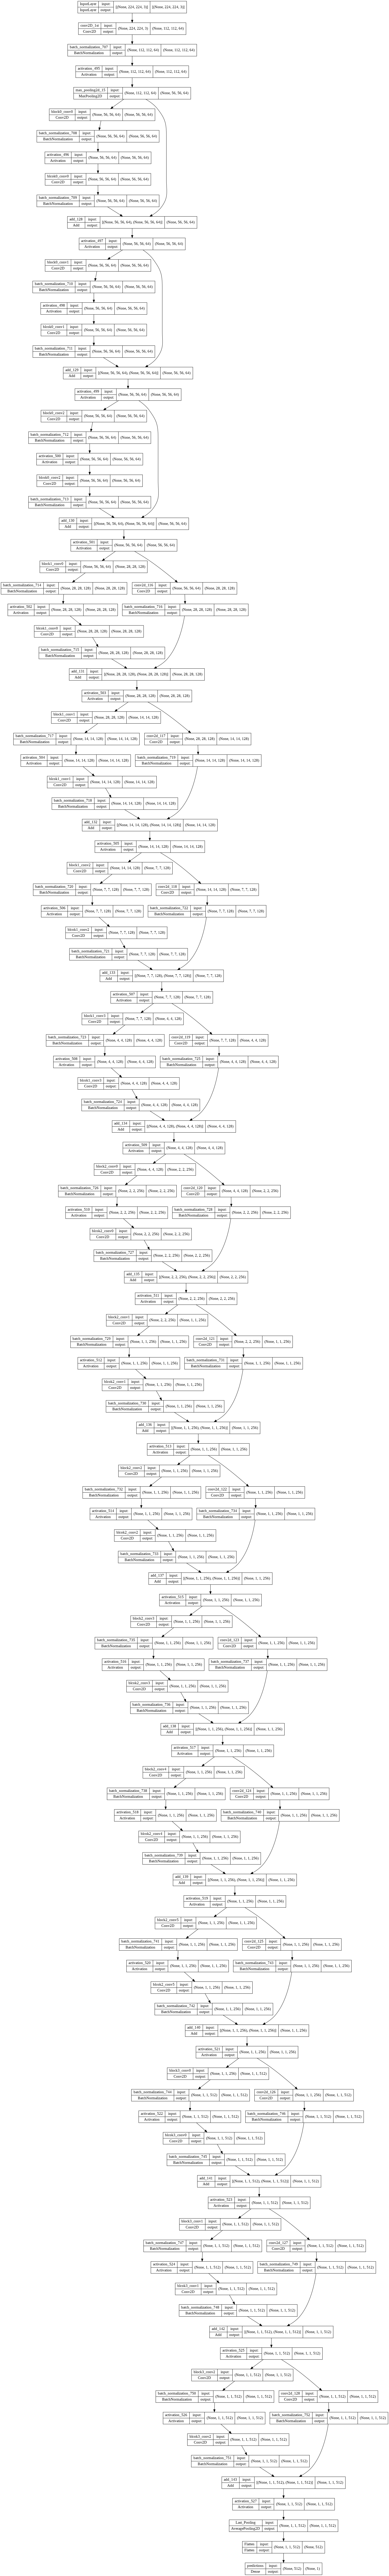

In [53]:
 ################# ResNet 34 model 생성 ########################
resnet_34 = build_resnet(input_shape=(224, 224,3), num_classes = 1, is_50 =False)

tf.keras.utils.plot_model(resnet_34, 'model_2.png', show_shapes = True)

In [54]:
################# ResNet 34 model 학습 ########################
resnet_34.compile(
    loss='BinaryCrossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_resnet34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 89s 130ms/step - loss: 0.7601 - accuracy: 0.5129 - val_loss: 0.7666 - val_accuracy: 0.5190
Epoch 2/50
581/581 [==============================] - 75s 129ms/step - loss: 0.7318 - accuracy: 0.5036 - val_loss: 0.7306 - val_accuracy: 0.5200
Epoch 3/50
581/581 [==============================] - 75s 128ms/step - loss: 0.7166 - accuracy: 0.5141 - val_loss: 0.7263 - val_accuracy: 0.5229
Epoch 4/50
581/581 [==============================] - 75s 129ms/step - loss: 0.7092 - accuracy: 0.5164 - val_loss: 0.7578 - val_accuracy: 0.5220
Epoch 5/50
581/581 [==============================] - 75s 129ms/step - loss: 0.7008 - accuracy: 0.5263 - val_loss: 0.7167 - val_accuracy: 0.5347
Epoch 6/50
581/581 [==============================] - 75s 129ms/step - loss: 0.6990 - accuracy: 0.5226 - val_loss: 0.7081 - val_accuracy: 0.5317
Epoch 7/50
581/581 [==============================] - 75s 129ms/step - loss: 0.6905 - accuracy: 0.5508 - val_loss: 0.7392 - val_ac

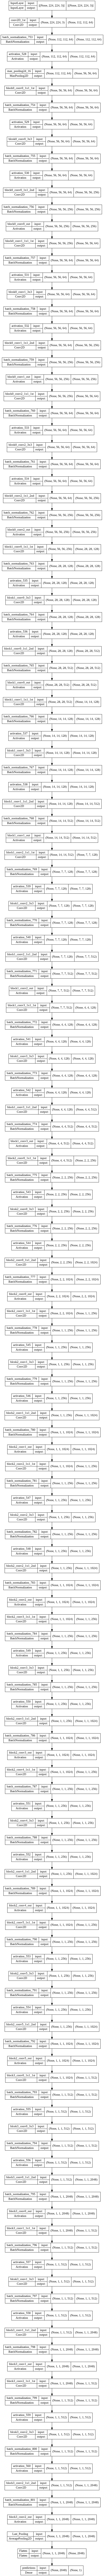

In [55]:
################# plainnet 50 model 생성 ########################
plainnet_50 = build_plainnet(input_shape=(224, 224,3), num_classes = 1, is_50 = True)

tf.keras.utils.plot_model(plainnet_50, 'model_3.png', show_shapes = True)

In [56]:
################# plainnet 50 model 학습 ########################
plainnet_50.compile(
    loss='BinaryCrossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 106s 158ms/step - loss: 0.7439 - accuracy: 0.4966 - val_loss: 1.0381 - val_accuracy: 0.5058
Epoch 2/50
581/581 [==============================] - 90s 156ms/step - loss: 0.7243 - accuracy: 0.5029 - val_loss: 0.9693 - val_accuracy: 0.5011
Epoch 3/50
581/581 [==============================] - 91s 156ms/step - loss: 0.7212 - accuracy: 0.4952 - val_loss: 1.1903 - val_accuracy: 0.4900
Epoch 4/50
581/581 [==============================] - 90s 155ms/step - loss: 0.7160 - accuracy: 0.4992 - val_loss: 1.4874 - val_accuracy: 0.4922
Epoch 5/50
581/581 [==============================] - 90s 156ms/step - loss: 0.7115 - accuracy: 0.5102 - val_loss: 2.4553 - val_accuracy: 0.4942
Epoch 6/50
581/581 [==============================] - 90s 156ms/step - loss: 0.7118 - accuracy: 0.5033 - val_loss: 1.1209 - val_accuracy: 0.5271
Epoch 7/50
581/581 [==============================] - 91s 156ms/step - loss: 0.7091 - accuracy: 0.5044 - val_loss: 1.1179 - val_a

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2D_1st (Conv2D)            (None, 112, 112, 64  256         ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization_1021 (Batc  (None, 112, 112, 64  256        ['conv2D_1st[0][0]']             
 hNormalization)                )                                                          

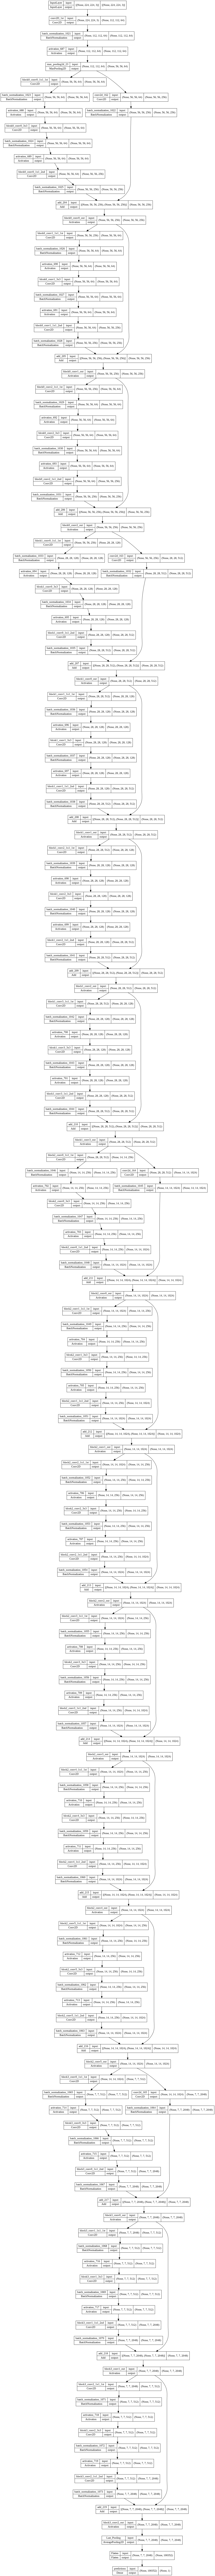

In [69]:
################# ResNet 50 model 생성 ########################
resnet_50 = build_resnet(input_shape=(224, 224,3), num_classes = 1, is_50 = True)

resnet_50.summary()
tf.keras.utils.plot_model(resnet_50, 'model_4.png', show_shapes = True)

In [70]:
################# ResNet 50 model 학습 ########################
resnet_50.compile(
    loss='BinaryCrossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 221s 355ms/step - loss: 1.0126 - accuracy: 0.5320 - val_loss: 0.9741 - val_accuracy: 0.5459
Epoch 2/50
581/581 [==============================] - 204s 351ms/step - loss: 0.9401 - accuracy: 0.5550 - val_loss: 0.9851 - val_accuracy: 0.5627
Epoch 3/50
581/581 [==============================] - 204s 350ms/step - loss: 0.8823 - accuracy: 0.5831 - val_loss: 1.3026 - val_accuracy: 0.5526
Epoch 4/50
581/581 [==============================] - 204s 351ms/step - loss: 0.8564 - accuracy: 0.6000 - val_loss: 1.0128 - val_accuracy: 0.5662
Epoch 5/50
581/581 [==============================] - 204s 351ms/step - loss: 0.8409 - accuracy: 0.6147 - val_loss: 0.8802 - val_accuracy: 0.6265
Epoch 6/50
581/581 [==============================] - 204s 351ms/step - loss: 0.8096 - accuracy: 0.6293 - val_loss: 0.9136 - val_accuracy: 0.6548
Epoch 7/50
581/581 [==============================] - 204s 352ms/step - loss: 0.7819 - accuracy: 0.6422 - val_loss: 1.3411 -

이제 34, 50 layer 들을 각각 plain 과 resnet으로 나눠 돌려보았으니 결과를 시각화해보겠습니다. 


## STEP 4. 데이터 시각화 

---

진행은 
1. 같은 레이어별 비교 (34 layer - plain, ResNet / 50 layer - plain, ResNet)
2. 모델 타입별 비교 (plain - 34, 50 / ResNet - 34, 50)
로 하겠습니다. 

이 논문의 경우 레이어별로 성능향상이 있다는 것도 좋지만, 그보다 **ResNet 구조를 통해 더 깊게 쌓아도 과적합이 일어나지 않는다는 것**이 핵심입니다.

따라서 1보단 2번의 비교를 통해 깊게 쌓아도 loss나 accuracy의 향상이 되는지 확인해보겠습니다. 

### 1. 시각화 - 같은 레이어별 비교
---
- 34 layer - plain, ResNet 
- 50 layer - plain, ResNet

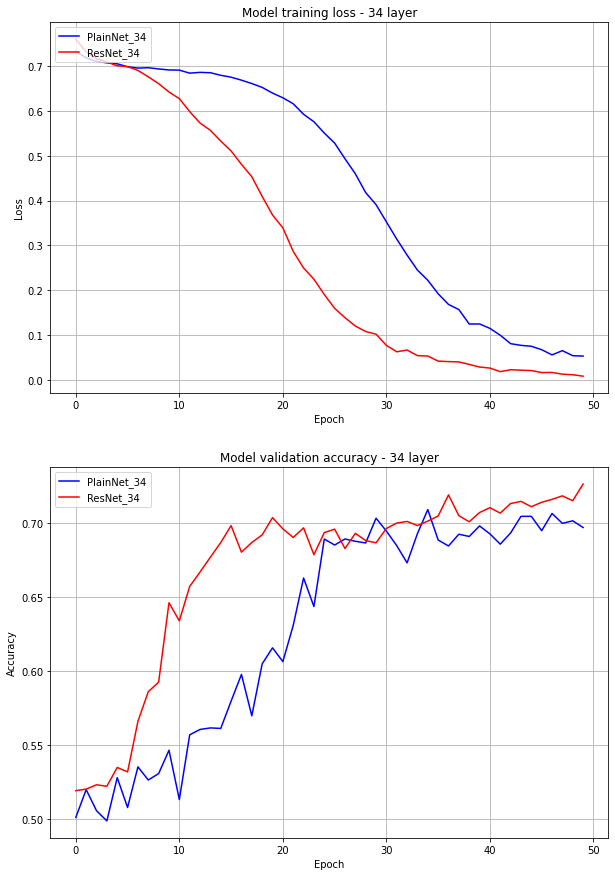

In [76]:
############## 34 layer - plain, ResNet 시각화 ################
plt.figure(figsize=(10, 15))

plt.subplot(2,1,1)
plt.plot(history_plain34.history['loss'], 'b')
plt.plot(history_resnet34.history['loss'], 'r')
plt.title('Model training loss - 34 layer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'ResNet_34'], loc='upper left')
plt.grid()


plt.subplot(2,1,2)
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.title('Model validation accuracy - 34 layer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'ResNet_34'], loc='upper left')
plt.grid()
plt.subplots_adjust()

plt.show()

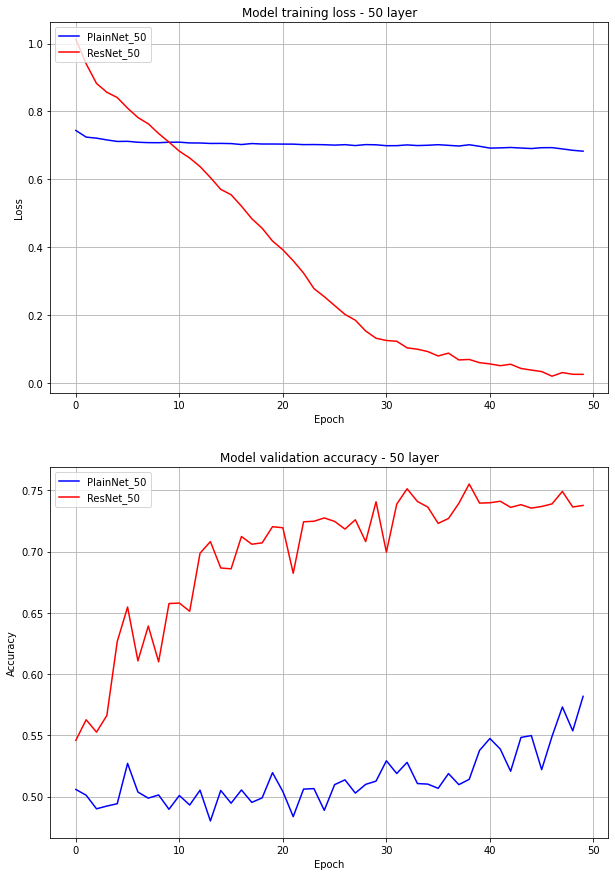

In [77]:
############## 50 layer - plain, ResNet / ################
plt.figure(figsize=(10, 15))

plt.subplot(2,1,1)
plt.plot(history_plainnet_50.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r')
plt.title('Model training loss - 50 layer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_50', 'ResNet_50'], loc='upper left')
plt.grid()


plt.subplot(2,1,2)
plt.plot(history_plainnet_50.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.title('Model validation accuracy - 50 layer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet_50', 'ResNet_50'], loc='upper left')
plt.grid()
plt.subplots_adjust()

plt.show()

### 2. 시각화 - 모델 타입별 비교 
---
- plain - 34, 50 layer
- ResNet - 34, 50 layer

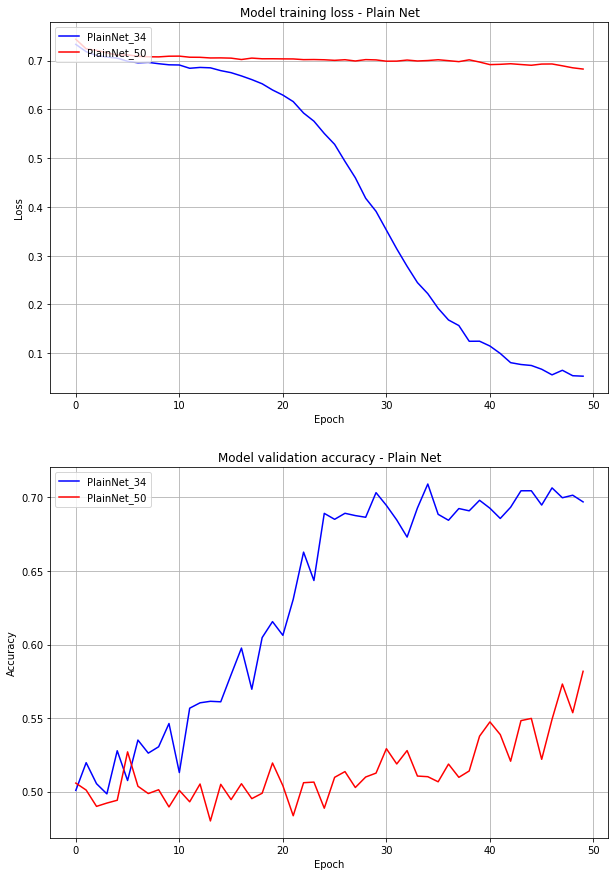

In [79]:
############## plain - 34, 50 시각화 ################
plt.figure(figsize=(10, 15))

plt.subplot(2,1,1)
plt.plot(history_plain34.history['loss'], 'b')
plt.plot(history_plainnet_50.history['loss'], 'r')
plt.title('Model training loss - Plain Net')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'PlainNet_50'], loc='upper left')
plt.grid()


plt.subplot(2,1,2)
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.plot(history_plainnet_50.history['val_accuracy'], 'r')
plt.title('Model validation accuracy - Plain Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'PlainNet_50'], loc='upper left')
plt.grid()
plt.subplots_adjust()

plt.show()

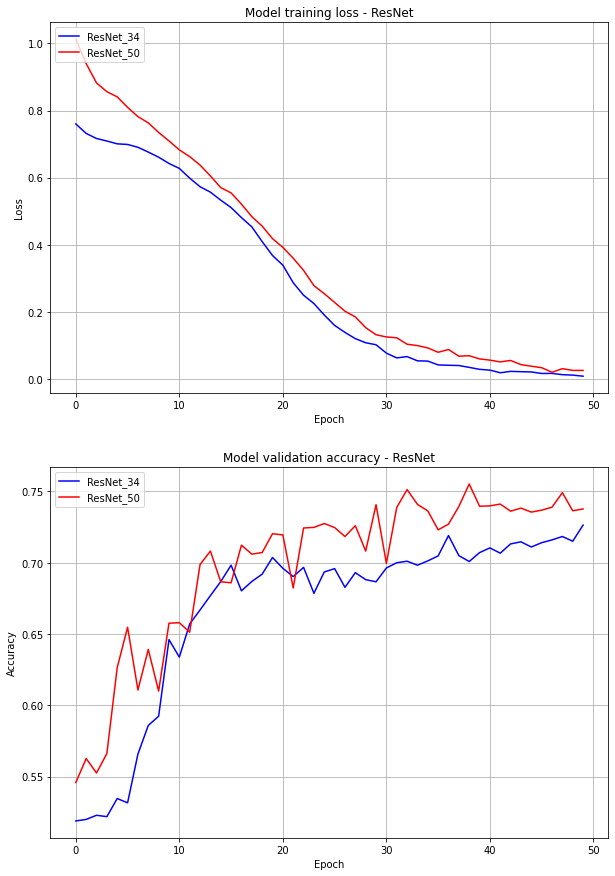

In [80]:
############## plain - 34, 50 시각화 ################
plt.figure(figsize=(10, 15))

plt.subplot(2,1,1)
plt.plot(history_resnet34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r')
plt.title('Model training loss - ResNet')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34', 'ResNet_50'], loc='upper left')
plt.grid()


plt.subplot(2,1,2)
plt.plot(history_resnet34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.title('Model validation accuracy - ResNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34', 'ResNet_50'], loc='upper left')
plt.grid()
plt.subplots_adjust()

plt.show()

## 회고 
---
- **밑바닥부터 시작하는 논문구현!**  
처음으로 논문구현을 해봤다! 논문 이해부터 코드로 짜기까지 거의 3일이 걸린 것 같은데, 돌아가는데 시간이 소요된 것도 있지만 처음이다보니 시간이 오래걸렸다. 하지만 점점 시간이 지나고 이해가 되가면서 더 재밌게 진행했다.  앞으로도 차근차근히 전진하자!

- **이게 되네?**  
이론으로만 이렇게 되는구나~ 라고 생각했던 것을 시각화 하니 수식으로만 이해했던 것이 확 와닿는다! 시간은 resnet 50이 생각했던 것 보단 오래걸렸지만, 코드를 구현하면서 parameter의 변화, loss, accuray의 변화를 보면서 residual network의 대단함을 느꼈다. He씨... 당신정말대단해...
